In [ ]:
import os
import gdown
import zipfile
import csv
import gdown
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img
from tensorflow.keras.utils import Sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import model_from_json

# Bug Classifier

## Data Preparation

### Dataset Download

In [ ]:
api = 'https://drive.google.com/uc?id=1HwbZemgag2jcb9QcEaJ1KcOajF8_xW36'

gdown.download(api, 'kaggle.json', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1HwbZemgag2jcb9QcEaJ1KcOajF8_xW36
To: /content/kaggle.json
100%|██████████| 65.0/65.0 [00:00<00:00, 74.5kB/s]


'kaggle.json'

In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d gauravduttakiit/agricultural-pests-dataset
!unzip agricultural-pests-dataset.zip -d agricultural-pests-dataset

Streaming output truncated to the last 5000 lines.
  inflating: agricultural-pests-dataset/test/earwig/earwig (307).jpg  
  inflating: agricultural-pests-dataset/test/earwig/earwig (308).jpg  
  inflating: agricultural-pests-dataset/test/earwig/earwig (309).jpg  
  inflating: agricultural-pests-dataset/test/earwig/earwig (31).jpg  
  inflating: agricultural-pests-dataset/test/earwig/earwig (315).jpg  
  inflating: agricultural-pests-dataset/test/earwig/earwig (33).jpg  
  inflating: agricultural-pests-dataset/test/earwig/earwig (331).jpg  
  inflating: agricultural-pests-dataset/test/earwig/earwig (334).jpg  
  inflating: agricultural-pests-dataset/test/earwig/earwig (338).jpg  
  inflating: agricultural-pests-dataset/test/earwig/earwig (34).jpg  
  inflating: agricultural-pests-dataset/test/earwig/earwig (343).jpg  
  inflating: agricultural-pests-dataset/test/earwig/earwig (348).jpg  
  inflating: agricultural-pests-dataset/test/earwig/earwig (35).jpg  
  inflating: agricultural-pest

### Dataset Cleaning

In [ ]:
#read the dataset
train=pd.read_csv('/content/agricultural-pests-dataset/train.csv')
test=pd.read_csv('/content/agricultural-pests-dataset/test.csv')

In [ ]:
#change directory
train_dir = '/content/agricultural-pests-dataset/train/'
test_dir = '/content/agricultural-pests-dataset/test/'

In [ ]:
#rename file path
train['filename']= train['filename'].str.replace('/kaggle/input/agricultural-pests-image-dataset/', train_dir)
test['filename']= test['filename'].str.replace('/kaggle/input/agricultural-pests-image-dataset/', test_dir)

In [ ]:
# classify whether they are spreading via wind
pest_labels = ['catterpillar', 'grasshopper', 'moth']
train1 = train.copy()
test1 = test.copy()
train1['wind'] = train1['label'].apply(lambda x: 1 if x in pest_labels else 0)
test1['wind'] = test1['label'].apply(lambda x: 1 if x in pest_labels else 0)

#change to string so the generator could read it
train1['wind'] = train1['wind'].astype(str)
test1['wind'] = test1['wind'].astype(str)

## ML Modelling

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.3,
                                   height_shift_range = 0.3,
                                   shear_range = 0.3,
                                   zoom_range = 0.35,
                                   horizontal_flip = True,
                                   fill_mode= 'nearest')

test_datagen = ImageDataGenerator( rescale = 1.0/255. )


train_generator = train_datagen.flow_from_dataframe(dataframe= train,
                                                    directory= train_dir,
                                                    x_col='filename',
                                                    y_col='label',
                                                    batch_size = 20,
                                                    class_mode = 'categorical',
                                                    target_size = (224, 224))

train_generator1 = train_datagen.flow_from_dataframe(dataframe= train1,
                                                    directory= train_dir,
                                                    x_col='filename',
                                                    y_col='wind',
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (224, 224))


test_generator =  test_datagen.flow_from_dataframe(dataframe= test,
                                                   directory= test_dir,
                                                   x_col='filename',
                                                   y_col='label',
                                                   batch_size  = 20,
                                                   class_mode  = 'categorical',
                                                   target_size = (224, 224))


test_generator1 =  test_datagen.flow_from_dataframe(dataframe= test1,
                                                   directory= test_dir,
                                                   x_col='filename',
                                                   y_col='wind',
                                                   batch_size  = 20,
                                                   class_mode  = 'binary',
                                                   target_size = (224,224))

Found 4395 validated image filenames belonging to 12 classes.
Found 4395 validated image filenames belonging to 2 classes.
Found 1099 validated image filenames belonging to 12 classes.
Found 1099 validated image filenames belonging to 2 classes.


In [ ]:
model_selection = ("mobilenet_v2", 224, 1280)
handle_base, pixels, FV_SIZE = model_selection
IMAGE_SIZE = (pixels, pixels)

MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
feature_extractor_layer = hub.KerasLayer(MODULE_HANDLE, input_shape=IMAGE_SIZE + (3,), trainable=False)

def dense_layers(features):
    x = tf.keras.layers.Flatten()(features)
    x = tf.keras.layers.Dense(2048, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x

def wind_pest(x):
    pest_spread = tf.keras.layers.Dense(1, activation='sigmoid', name = 'wind_pest')(x)
    return pest_spread

def final_model(inputs):
    # features
    feature_cnn = feature_extractor_layer(inputs)
    # dense layers
    dense_layer = dense_layers(feature_cnn)
    # pest label and spread
    wind_pest_output = wind_pest(dense_layer)
    # define the TensorFlow Keras model using the inputs and outputs to model
    model = tf.keras.Model(inputs = inputs, outputs = wind_pest_output)
    return model

def define_and_compile_model():
    # define the input layer
    inputs = tf.keras.layers.Input(shape=(224,224,3))
    # create the model
    model = final_model(inputs)
    # compile model
    model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 0.0001),
                loss= 'binary_crossentropy',
                metrics = ['accuracy'])
    return model

model = define_and_compile_model()

EPOCHS = 15

BATCH_SIZE = 32

class myCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') >= 0.95):
          self.model.stop_training = True
callbacks = myCallback()

history = model.fit(
    train_generator1,
    validation_data= test_generator1,
    epochs= EPOCHS,
    callbacks= [callbacks]
)

In [ ]:
model.save("wind_spread_classifier_model.h5")

try:
    from google.colab import files
    files.download('wind_spread_classifier_model.h5')
except ImportError:
    pass

In [ ]:
class CombinedGenerator(Sequence):
    def __init__(self, generator1, generator2):
        self.generator1 = generator1
        self.generator2 = generator2

    def __len__(self):
        return min(len(self.generator1), len(self.generator2))

    def __getitem__(self, index):
        x1, y1 = self.generator1[index]
        x2, y2 = self.generator2[index]
        return x1, {'pest_label': y1, 'wind_pest': y2}

# Instantiate the combined generators for training and validation
train_combined_generator = CombinedGenerator(train_generator, train_generator1)
validation_combined_generator = CombinedGenerator(test_generator, test_generator1)


In [ ]:
model_selection = ("mobilenet_v2", 224, 1280)
handle_base, pixels, FV_SIZE = model_selection
IMAGE_SIZE = (pixels, pixels)

MODULE_HANDLE = "https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
feature_extractor_layer = hub.KerasLayer(MODULE_HANDLE, input_shape=IMAGE_SIZE + (3,), trainable=False)

def dense_layers(features):
    x = tf.keras.layers.Flatten()(features)
    x = tf.keras.layers.Dense(2048, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x

def pest_label(x):
    pest_label = tf.keras.layers.Dense(12, activation='softmax', name = 'pest_label')(x)
    return pest_label

def final_model(inputs):
    # features
    feature_cnn = feature_extractor_layer(inputs)
    # dense layers
    dense_layer = dense_layers(feature_cnn)
    # pest label and spread
    pest_label_output = pest_label(dense_layer)
    # define the TensorFlow Keras model using the inputs and outputs to model
    model = tf.keras.Model(inputs = inputs, outputs = pest_label_output)
    return model

def define_and_compile_model():
    # define the input layer
    inputs = tf.keras.layers.Input(shape=(224,224,3))
    # create the model
    model = final_model(inputs)
    # compile model
    model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate= 0.0001),
                loss= 'categorical_crossentropy',
                metrics = ['accuracy'])

    return model

In [ ]:
# define model
model = define_and_compile_model()
# print model layers
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2048)              2623488   
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                             

## ML Training

In [ ]:
EPOCHS = 15

BATCH_SIZE = 32

class myCallback(tf.keras.callbacks.Callback):
      def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy') >= 0.95):
          self.model.stop_training = True
callbacks = myCallback()

In [ ]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    callbacks=[callbacks]
)

Epoch 1/15
220/220 [==============================] - 269s 1s/step - loss: 1.4467 - accuracy: 0.5595 - val_loss: 0.8682 - val_accuracy: 0.7716
Epoch 2/15
220/220 [==============================] - 252s 1s/step - loss: 0.8581 - accuracy: 0.7381 - val_loss: 0.5893 - val_accuracy: 0.8298
Epoch 3/15
220/220 [==============================] - 250s 1s/step - loss: 0.7622 - accuracy: 0.7625 - val_loss: 0.6019 - val_accuracy: 0.8298
Epoch 4/15
220/220 [==============================] - 235s 1s/step - loss: 0.6640 - accuracy: 0.7893 - val_loss: 0.5417 - val_accuracy: 0.8526
Epoch 5/15
220/220 [==============================] - 247s 1s/step - loss: 0.6164 - accuracy: 0.8039 - val_loss: 0.5341 - val_accuracy: 0.8462
Epoch 6/15
220/220 [==============================] - 242s 1s/step - loss: 0.5719 - accuracy: 0.8218 - val_loss: 0.4983 - val_accuracy: 0.8571
Epoch 7/15
220/220 [==============================] - 290s 1s/step - loss: 0.5425 - accuracy: 0.8319 - val_loss: 0.5021 - val_accuracy: 0.8590

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print("Accuracy", accuracy)

55/55 [==============================] - 35s 628ms/step - loss: 0.4793 - accuracy: 0.8626
Accuracy 0.8626023530960083


In [ ]:
model.save("pest_label_classifier.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
try:
    from google.colab import files
    files.download('pest_label_classifier.h5')
except ImportError:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


## Convert to JSON

In [ ]:
import gdown
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import model_from_json

# URLs for the models
pest_label_classifier_url = 'https://drive.google.com/uc?id=1rhmfKxCwmicpmztpE8XSrRIqSAV5KEUC'
wind_spread_classifier_url = 'https://drive.google.com/uc?id=1NuGu-t7HeeBC1JqCht7shYy_bMjhno09'

# Download the models
gdown.download(pest_label_classifier_url, 'pest_label_classifier.h5', quiet=False)
gdown.download(wind_spread_classifier_url, 'wind_spread_classifier.h5', quiet=False)

# Custom objects dictionary to include KerasLayer
custom_objects = {'KerasLayer': hub.KerasLayer}

# Load the models with custom objects
pest_label_model = tf.keras.models.load_model('pest_label_classifier.h5', custom_objects=custom_objects)
wind_spread_model = tf.keras.models.load_model('wind_spread_classifier.h5', custom_objects=custom_objects)

# Save model architecture to JSON
pest_label_model_json = pest_label_model.to_json()
with open('pest_label_classifier.json', 'w') as json_file:
    json_file.write(pest_label_model_json)

wind_spread_model_json = wind_spread_model.to_json()
with open('wind_spread_classifier.json', 'w') as json_file:
    json_file.write(wind_spread_model_json)

# Save model weights to HDF5
pest_label_model.save_weights('pest_label_weights.h5')
wind_spread_model.save_weights('wind_spread_weights.h5')

# Convert the models to TensorFlow.js format
!pip install tensorflowjs
!tensorflowjs_converter --input_format keras pest_label_classifier.h5 ./tfjs_pest_label_model
!tensorflowjs_converter --input_format keras wind_spread_classifier.h5 ./tfjs_wind_spread_model

Downloading...
From: https://drive.google.com/uc?id=1rhmfKxCwmicpmztpE8XSrRIqSAV5KEUC
To: /content/pest_label_classifier.h5
100%|██████████| 72.5M/72.5M [00:00<00:00, 224MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NuGu-t7HeeBC1JqCht7shYy_bMjhno09
To: /content/wind_spread_classifier.h5
100%|██████████| 72.4M/72.4M [00:00<00:00, 169MB/s]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 423.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 87.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 82.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 84.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 84.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 34.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
   

2024-06-03 23:52:18.815511: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-06-03 23:52:24.902112: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 5, in <module>
    from tensorflowjs.converters.converter import pip_main
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/__init__.py", line 21, in <module>
    from tensorflowjs import converters
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/__init__.py", line 21, in <module>
    from tensorflowjs.converters.converter import convert
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 29, in <module>
    import tensorflow.compat.v1 as tf1
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/__init__.py", line 462, in <module>
    importlib.import_module("keras.src.optimize

## Test

In [ ]:
# URLs for the models
pest_label_classifier_url = 'https://drive.google.com/uc?id=1rhmfKxCwmicpmztpE8XSrRIqSAV5KEUC'
wind_spread_classifier_url = 'https://drive.google.com/uc?id=1NuGu-t7HeeBC1JqCht7shYy_bMjhno09'

# Download the models
gdown.download(pest_label_classifier_url, 'pest_label_classifier.h5', quiet=False)
gdown.download(wind_spread_classifier_url, 'wind_spread_classifier.h5', quiet=False)

# Custom objects dictionary to include KerasLayer
custom_objects = {'KerasLayer': hub.KerasLayer}

# Load the model
model = tf.keras.models.load_model('wind_spread_classifier_url.h5', custom_objects=custom_objects)

# Summary of the model
model.summary()

Downloading...
From: https://drive.google.com/uc?id=1rhmfKxCwmicpmztpE8XSrRIqSAV5KEUC
To: /content/pest_label_classifier.h5
100%|██████████| 72.5M/72.5M [00:01<00:00, 38.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NuGu-t7HeeBC1JqCht7shYy_bMjhno09
To: /content/wind_spread_classifier.h5
100%|██████████| 72.4M/72.4M [00:01<00:00, 47.0MB/s]


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2048)              2623488   
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 1024)              2098176   
                                                             

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input, decode_predictions

# Load a sample image
img_path = '/content/cacing-tanah-sebagai-obat-alami-dan-indikator-polusi.jpg'
img = image.load_img(img_path, target_size=(224, 224))

# Preprocess the image
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Make predictions
preds = model.predict(x)
print("Predicted:", preds)

1/1 [==============================] - 1s 811ms/step
Predicted: [[1.0342215e-04 6.8098470e-06 2.4722199e-06 5.8457766e-02 9.3824339e-01
  2.8054803e-03 1.2929759e-07 7.8532375e-06 3.5442124e-04 4.9051359e-06
  3.1822890e-06 1.0141022e-05]]


# Wind Prediction (LSTM)

## Data Preparation

In [ ]:
bmkg = 'https://drive.google.com/uc?id=1ko2OVkd1auOxcWIDegXOUZDsBtO07NyX'
gdown.download(bmkg, 'bmkg.zip')
!unzip bmkg.zip -d bmkg

Downloading...
From: https://drive.google.com/uc?id=1ko2OVkd1auOxcWIDegXOUZDsBtO07NyX
To: /content/bmkg.zip
100%|██████████| 1.25M/1.25M [00:00<00:00, 113MB/s]

Archive:  bmkg.zip
  inflating: bmkg/2014_01.xlsx       
  inflating: bmkg/2014_02.xlsx       
  inflating: bmkg/2014_03.xlsx       
  inflating: bmkg/2014_04.xlsx       
  inflating: bmkg/2014_05.xlsx       
  inflating: bmkg/2014_06.xlsx       
  inflating: bmkg/2014_07.xlsx       
  inflating: bmkg/2014_08.xlsx       
  inflating: bmkg/2014_09.xlsx       
  inflating: bmkg/2014_10.xlsx       
  inflating: bmkg/2014_11.xlsx       
  inflating: bmkg/2014_12.xlsx       
  inflating: bmkg/2015_01.xlsx       
  inflating: bmkg/2015_02.xlsx       
  inflating: bmkg/2015_03.xlsx       
  inflating: bmkg/2015_04.xlsx       
  inflating: bmkg/2015_05.xlsx       
  inflating: bmkg/2015_06.xlsx       
  inflating: bmkg/2015_07.xlsx       
  inflating: bmkg/2015_08.xlsx       
  inflating: bmkg/2015_09.xlsx       
  inflating: bmkg/2015_10.xlsx       
  inflating: bmkg/2015_11.xlsx       
  inflating: bmkg/2015_12.xlsx       
  inflating: bmkg/2016_01.xlsx       
  inflating: bmkg/2016_02.xlsx 

In [ ]:
# Path to the directory containing the Excel files
data_dir = 'bmkg'

# List all Excel files in the directory
files = [f for f in os.listdir(data_dir) if f.endswith('.xlsx')]

# Initialize an empty list to hold DataFrames
df_list = []

# Loop through each file and read the data
for file in files:
    file_path = os.path.join(data_dir, file)
    df = pd.read_excel(file_path, skiprows=8, nrows=31)  # Read starting from row 9, 31 rows (index 8 means 9th row)
    df_list.append(df)

# Concatenate all DataFrames in the list
combined_df = pd.concat(df_list, ignore_index=True)
bmkg_df = combined_df.iloc[:-6]

In [ ]:
# fix the date format
bmkg_df['Tanggal'] = pd.to_datetime(bmkg_df['Tanggal'], format='%d-%m-%Y')

# Sort the DataFrame by the date column
bmkg_df = bmkg_df.sort_values(by='Tanggal')

# reset index
bmkg_df = bmkg_df.reset_index(drop=True)

#drop columns
bmkg_df = bmkg_df.drop(columns = ['ff_x', 'ddd_x'])

# rename column
bmkg_df = bmkg_df.rename(columns= {'Tanggal':'date','ff_avg':'v_avg', 'ddd_car':'arah_byk'})

<ipython-input-10-8e2d2193be7a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bmkg_df['Tanggal'] = pd.to_datetime(bmkg_df['Tanggal'], format='%d-%m-%Y')


In [ ]:
# Calculate the mode for each column
mode_v_avg = bmkg_df['v_avg'].mode()[0]
mode_arah_byk = bmkg_df['arah_byk'].mode()[0]

# Fill missing values with the mode
bmkg_df['v_avg'].fillna(mode_v_avg, inplace=True)
bmkg_df['arah_byk'].fillna(mode_arah_byk, inplace=True)


## Model 1

In [ ]:
bmkg_avg = bmkg_df.drop(columns=['arah_byk'])

In [ ]:
bmkg_avg.head()

,date,v_avg,day_of_year
0,2014-01-01,0.285714,1
1,2014-01-02,0.285714,2
2,2014-01-03,0.285714,3
3,2014-01-04,0.142857,4
4,2014-01-05,0.142857,5


In [ ]:
bmkg_avg.to_csv('bmkg_dataset.csv', index=False)
#3767 rows × 10 columns

## Data Preprocessing

In [ ]:
# Convert date to numerical format (e.g., day of the year)
bmkg_avg['date'] = pd.to_datetime(bmkg_df['date'])
bmkg_avg['day_of_year'] = bmkg_df['date'].dt.dayofyear

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the scaler
scaler = MinMaxScaler()

# Normalize the 'v_avg' column
bmkg_avg['v_avg'] = scaler.fit_transform(bmkg_df[['v_avg']])

## Viz Plot

In [ ]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

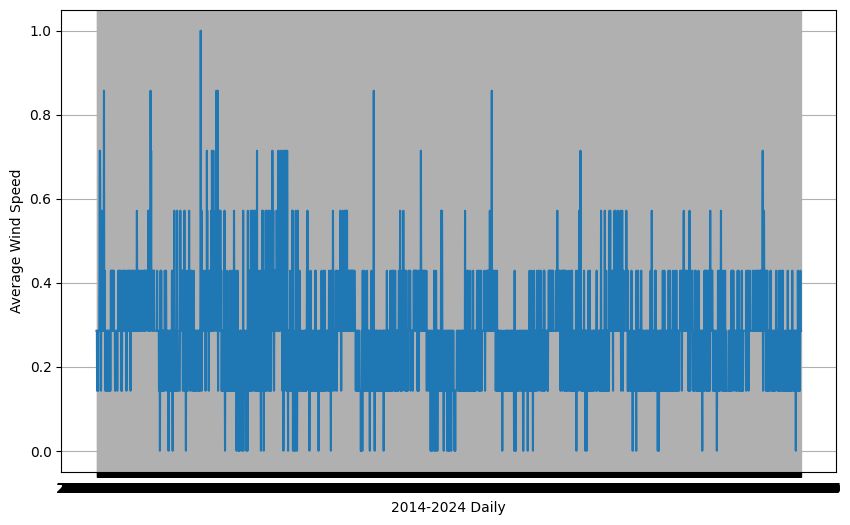

In [ ]:
# Initialize lists
time_step = []
avg_wind = []

# Open CSV file
with open('/content/bmkg_dataset.csv') as csvfile:

  # Initialize reader
  reader = csv.reader(csvfile, delimiter=',')

  # Skip the first line
  next(reader)

  # Append row and sunspot number to lists
  for row in reader:
    time_step.append(row[0]) #first column is 'date'
    avg_wind.append(float(row[1])) #second column is 'v_avg'


# Convert lists to numpy arrays
time = np.array(time_step)
series = np.array(avg_wind)

# Preview the data
plot_series(time, series, xlabel='2014-2024 Daily', ylabel='Average Wind Speed')

## Train Test split

In [ ]:
# Define the split time
split_time = 3500

# Get the train set
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

NameError: name 'time' is not defined

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset

In [ ]:
# Parameters
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

# Generate the dataset windows
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
test_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)

## ML Model Train

In [ ]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation="relu", padding='causal', input_shape=[window_size, 1]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

# Print the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 30, 128)           512       
                                                                 
 batch_normalization_3 (Bat  (None, 30, 128)           512       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_4 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                      

In [ ]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

# Train the model
history = model.fit(train_set, test_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
109/109 [==============================] - 22s 144ms/step - loss: 381.7730 - lr: 1.0000e-08
Epoch 2/100
109/109 [==============================] - 15s 139ms/step - loss: 336.3485 - lr: 1.1220e-08
Epoch 3/100
109/109 [==============================] - 15s 141ms/step - loss: 305.6835 - lr: 1.2589e-08
Epoch 4/100
109/109 [==============================] - 15s 141ms/step - loss: 280.8412 - lr: 1.4125e-08
Epoch 5/100
109/109 [==============================] - 15s 141ms/step - loss: 269.9906 - lr: 1.5849e-08
Epoch 6/100
109/109 [==============================] - 15s 139ms/step - loss: 249.1082 - lr: 1.7783e-08
Epoch 7/100
109/109 [==============================] - 15s 140ms/step - loss: 235.5391 - lr: 1.9953e-08
Epoch 8/100
109/109 [==============================] - 16s 142ms/step - loss: 224.4532 - lr: 2.2387e-08
Epoch 9/100
109/109 [==============================] - 15s 141ms/step - loss: 211.0567 - lr: 2.5119e-08
Epoch 10/100
109/109 [==============================] - 16s 145m

(1e-08, 0.001, 0.0, 100.0)

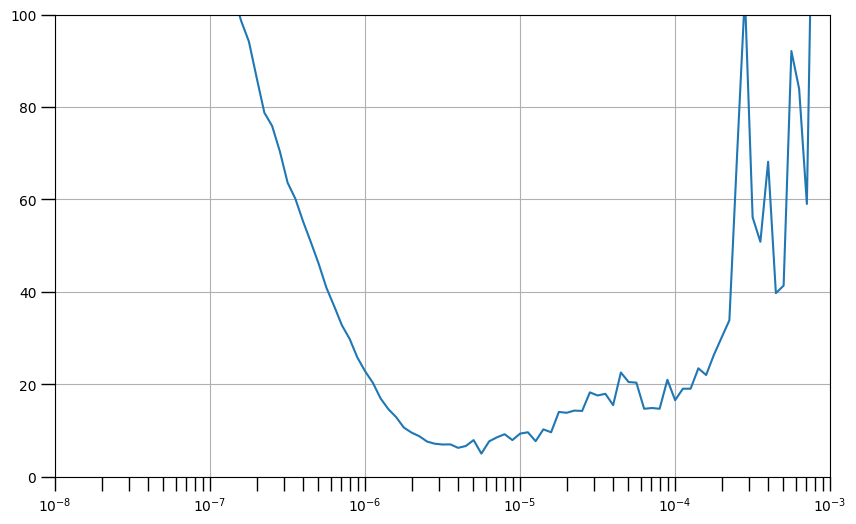

In [ ]:
# Define the learning rate array
lrs = 1e-8 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-8, 1e-3, 0, 100])

In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=1, activation="relu", padding='causal', input_shape=[window_size, 1]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),  # Increase dropout rate
    tf.keras.layers.LSTM(128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Add L2 regularization
    tf.keras.layers.Dropout(0.3),  # Increase dropout rate
    tf.keras.layers.LSTM(128, kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Add L2 regularization
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),  # Increase dropout rate
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 400)
])

# Set the learning rate
learning_rate = 5e-5

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-7)

# Train the model
history = model.fit(train_set, epochs=100, validation_data=test_set, callbacks=[early_stopping, lr_reduction])

# Evaluate the model
loss, mae = model.evaluate(test_set)
print(f"Test Loss: {loss}")
print(f"Test MAE: {mae}")


Epoch 1/100
109/109 [==============================] - 23s 153ms/step - loss: 87.8095 - mae: 84.0841 - val_loss: 35.4000 - val_mae: 31.6585 - lr: 5.0000e-05
Epoch 2/100
109/109 [==============================] - 15s 137ms/step - loss: 41.3786 - mae: 37.6386 - val_loss: 11.9183 - val_mae: 8.1710 - lr: 5.0000e-05
Epoch 3/100
109/109 [==============================] - 15s 136ms/step - loss: 29.1929 - mae: 25.4614 - val_loss: 13.9625 - val_mae: 10.2391 - lr: 5.0000e-05
Epoch 4/100
109/109 [==============================] - 16s 144ms/step - loss: 21.6464 - mae: 17.9223 - val_loss: 11.3228 - val_mae: 7.6004 - lr: 5.0000e-05
Epoch 5/100
109/109 [==============================] - 15s 133ms/step - loss: 18.9880 - mae: 15.2735 - val_loss: 17.2300 - val_mae: 13.5227 - lr: 5.0000e-05
Epoch 6/100
109/109 [==============================] - 15s 137ms/step - loss: 15.0211 - mae: 11.3133 - val_loss: 8.6691 - val_mae: 4.9688 - lr: 5.0000e-05
Epoch 7/100
109/109 [==============================] - 15s 134

In [ ]:
model.save("avg_wind_speed.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
try:
    from google.colab import files
    files.download('avg_wind_speed.h5')
except ImportError:
    pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import gdown
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import model_from_json

# URLs for the models
avg_wind_speed_url = 'https://drive.google.com/uc?id=1xvRl8GhK6cEbnI8-Bpd5cNqGyTkDUzPZ'

# Download the models
gdown.download(avg_wind_speed_url, 'avg_wind_speed.h5', quiet=False)

# Custom objects dictionary to include KerasLayer
custom_objects = {'KerasLayer': hub.KerasLayer}

# Load the models with custom objects
avg_wind_speed_model = tf.keras.models.load_model('avg_wind_speed.h5', custom_objects=custom_objects)

# Save model architecture to JSON
avg_wind_speed_model_json = avg_wind_speed_model.to_json()
with open('avg_wind_speed.json', 'w') as json_file:
    json_file.write(avg_wind_speed_model_json)

# Save model weights to HDF5
avg_wind_speed_model.save_weights('avg_wind_speed_weights.h5')

# Convert the models to TensorFlow.js format
!pip install tensorflowjs
!tensorflowjs_converter --input_format keras avg_wind_speed.h5 ./tfjs_avg_wind_speed_model

Downloading...
From: https://drive.google.com/uc?id=1xvRl8GhK6cEbnI8-Bpd5cNqGyTkDUzPZ
To: /content/avg_wind_speed.h5
100%|██████████| 2.27M/2.27M [00:00<00:00, 85.4MB/s]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 58.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 24.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
     

2024-06-16 19:41:37.041747: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Model 2 (Wind Direction)

In [ ]:
bmkg_dir = bmkg_df.drop(columns=['v_avg'])

In [ ]:
bmkg_dir.to_csv('bmkg_dir.csv', index=False)
#3767 rows × 10 columns

In [ ]:
# Convert date to numerical format (e.g., day of the year)
bmkg_dir['date'] = pd.to_datetime(bmkg_df['date'])
bmkg_dir['day_of_year'] = bmkg_df['date'].dt.dayofyear

In [ ]:
from sklearn.preprocessing import OneHotEncoder

df = pd.read_csv('/content/bmkg_dir.csv')

# One-Hot Encode the wind direction
encoder = OneHotEncoder(sparse=False)
wind_direction_encoded = encoder.fit_transform(df[['arah_byk']])

encoded_columns = [f"arah_byk_{category}" for category in encoder.categories_[0]]
df_encoded = pd.concat([df.drop(columns=['arah_byk']), pd.DataFrame(wind_direction_encoded, columns=encoded_columns)], axis=1)

print(df_encoded.head())

         date  arah_byk_C   arah_byk_E   arah_byk_N   arah_byk_NE  \
0  2014-01-01          0.0          0.0          0.0          0.0   
1  2014-01-02          0.0          0.0          0.0          0.0   
2  2014-01-03          0.0          0.0          0.0          0.0   
3  2014-01-04          0.0          0.0          1.0          0.0   
4  2014-01-05          0.0          1.0          0.0          0.0   

   arah_byk_NW  arah_byk_S   arah_byk_SE  arah_byk_SW  arah_byk_W   
0          0.0          1.0          0.0          0.0          0.0  
1          0.0          1.0          0.0          0.0          0.0  
2          0.0          1.0          0.0          0.0          0.0  
3          0.0          0.0          0.0          0.0          0.0  
4          0.0          0.0          0.0          0.0          0.0  


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# Define a function to create sequences
def create_sequences(data, target, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = target[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define the sequence length
seq_length = 30

# Prepare the feature set and target set
features = df_encoded.drop(columns=['date']).values
target = df_encoded[encoded_columns].values

# Create sequences for features and targets
X, y = create_sequences(features, target, seq_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the Model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=256, kernel_size=3, strides=1, activation="relu", padding='causal', input_shape=(seq_length, X_train.shape[2])),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),  # Adjust dropout rate
    tf.keras.layers.LSTM(256, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.4),  # Adjust dropout rate
    tf.keras.layers.LSTM(256, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.4),  # Adjust dropout rate
    tf.keras.layers.LSTM(256, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),  # Adjust dropout rate
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),  # Adjust dropout rate
    tf.keras.layers.Dense(len(encoded_columns), activation="softmax")
])

# Print the model summary
model.summary()

# Set the learning rate
initial_learning_rate = 1e-4

# Set the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-7)

# Set the training parameters
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=["accuracy"])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stopping, lr_reduction, lr_scheduler])

# Evaluate the model
loss, accuracy = model.evaluate(X_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 256)           7168      
                                                                 
 batch_normalization (Batch  (None, 30, 256)           1024      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 30, 256)           0         
                                                                 
 lstm (LSTM)                 (None, 30, 256)           525312    
                                                                 
 dropout_1 (Dropout)         (None, 30, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 256)           525312    
                                                        

In [ ]:
model.save("wind_direction.h5")

try:
    from google.colab import files
    files.download('wind_direction.h5')
except ImportError:
    pass

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import gdown
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import model_from_json

# URLs for the models
avg_wind_speed_url = 'https://drive.google.com/uc?id=1xvRl8GhK6cEbnI8-Bpd5cNqGyTkDUzPZ'

# Download the models
gdown.download(avg_wind_speed_url, 'avg_wind_speed.h5', quiet=False)

# Custom objects dictionary to include KerasLayer
custom_objects = {'KerasLayer': hub.KerasLayer}

# Load the models with custom objects
avg_wind_speed_model = tf.keras.models.load_model('avg_wind_speed.h5', custom_objects=custom_objects)

# Save model architecture to JSON
avg_wind_speed_model_json = avg_wind_speed_model.to_json()
with open('avg_wind_speed.json', 'w') as json_file:
    json_file.write(avg_wind_speed_model_json)

# Save model weights to HDF5
avg_wind_speed_model.save_weights('avg_wind_speed_weights.h5')

# Convert the models to TensorFlow.js format
!pip install tensorflowjs
!tensorflowjs_converter --input_format keras avg_wind_speed.h5 ./tfjs_avg_wind_speed_model

## Test Model Wind Direction

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.model_selection import train_test_split

# Load the CSV file into a DataFrame
df = pd.read_csv('/content/bmkg_dir.csv')

# One-Hot Encode the wind direction
encoder = OneHotEncoder(sparse_output=False)
wind_direction_encoded = encoder.fit_transform(df[['arah_byk']])

encoded_columns = [f"arah_byk_{category}" for category in encoder.categories_[0]]
df_encoded = pd.concat([df.drop(columns=['arah_byk']), pd.DataFrame(wind_direction_encoded, columns=encoded_columns)], axis=1)

# Ensure that the date column is not included in the model input
df_encoded.drop(columns=['date'], inplace=True)

# Verify the combined DataFrame
print(df_encoded.head())

# Define the sequence length
seq_length = 30  # You can adjust this value

# Prepare the input data for the LSTM model
def create_sequences(data, target, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = target[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Prepare the feature set and target set
features = df_encoded.values
target = wind_direction_encoded

# Create sequences for features and targets
X, y = create_sequences(features, target, seq_length)

# Ensure the shapes match the model's expected input shape
print("X shape:", X.shape)  # Should be (samples, 30, 9)
print("y shape:", y.shape)  # Should be (samples, 9)

# Convert data types to ensure compatibility
X = X.astype(np.float32)
y = y.astype(np.float32)

# Split the data into training and testing sets
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Load the trained model
from tensorflow.keras.models import load_model

model = load_model('/content/wind_direction.h5')

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Make predictions with the model
predictions = model.predict(X_test)
print(predictions)


   arah_byk_C   arah_byk_E   arah_byk_N   arah_byk_NE  arah_byk_NW  \
0          0.0          0.0          0.0          0.0          0.0   
1          0.0          0.0          0.0          0.0          0.0   
2          0.0          0.0          0.0          0.0          0.0   
3          0.0          0.0          1.0          0.0          0.0   
4          0.0          1.0          0.0          0.0          0.0   

   arah_byk_S   arah_byk_SE  arah_byk_SW  arah_byk_W   
0          1.0          0.0          0.0          0.0  
1          1.0          0.0          0.0          0.0  
2          1.0          0.0          0.0          0.0  
3          0.0          0.0          0.0          0.0  
4          0.0          0.0          0.0          0.0  
X shape: (3737, 30, 9)
y shape: (3737, 9)
24/24 [==============================] - 4s 109ms/step - loss: 5.4220 - accuracy: 0.5668
Test Loss: 5.421996593475342
Test Accuracy: 0.5668449401855469
24/24 [==============================] - 4s 107ms

# Trash

In [ ]:
def model_forecast(model, series, window_size, batch_size):
    """Uses an input model to generate predictions on data windows

    Args:
      model (TF Keras Model) - model that accepts data windows
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the window
      batch_size (int) - the batch size

    Returns:
      forecast (numpy array) - array containing predictions
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))

    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)

    # Get predictions on the entire dataset
    forecast = model.predict(dataset)

    return forecast

In [ ]:
# Reduce the original series
forecast_series = series[split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()

# Plot the results
plot_series(time_valid, (x_valid, results))
model.summary()

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'model' (type Functional).
    
    Input 0 of layer "lstm" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, None)
    
    Call arguments received by layer 'model' (type Functional):
      • inputs=tf.Tensor(shape=(None, None), dtype=float64)
      • training=False
      • mask=None


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from sklearn.preprocessing import OneHotEncoder

# OneHotEncoder dari scikit-learn
encoder = OneHotEncoder(sparse=False)
encoded_data = encoder.fit_transform(bmkg_df)
# Input layer
inputs = Input(shape=(input_data.shape[1], input_data.shape[2]))

x = LSTM(50, return_sequences=True)(inputs)
x = LSTM(50, return_sequences=False)(x)

# Dense output layer
output_layer = Dense(1)(X)

#Output for v_avg
v_avg_output = Dense(1, name='v_avg_output')(x)

# Output for arah_byk (one-hot encoded direction)
arah_byk_output = Dense(1, activation='softmax', name='arah_byk_output')(x)

# Define the model with two outputs
model = Model(inputs=inputs, outputs=[v_avg_output, arah_byk_output])


# Kompilasi model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error', 'mean_squared_error'])
# Menyimpan model dalam format SavedModel
model.save('my_model')

In [ ]:
# @title
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense

# Define the LSTM model
input_shape = (time_step, X.shape[2])
inputs = Input(shape=input_shape)
x = LSTM(50, return_sequences=True)(inputs)
x = LSTM(50, return_sequences=False)(x)

# Output for v_avg
v_avg_output = Dense(1, name='v_avg_output')(x)

# Output for arah_byk (one-hot encoded direction)
arah_byk_output = Dense(y_arah_byk.shape[1], activation='softmax', name='arah_byk_output')(x)

# Define the model with two outputs
model = Model(inputs=inputs, outputs=[v_avg_output, arah_byk_output])

# Compile the model
model.compile(optimizer='adam',
              loss={'v_avg_output': 'mean_squared_error', 'arah_byk_output': 'categorical_crossentropy'},
              metrics={'v_avg_output': 'mae', 'arah_byk_output': 'accuracy'})

# Display the model summary
model.summary()

# Train the model
history = model.fit(X_train,
                    {'v_avg_output': y_v_avg_train, 'arah_byk_output': y_arah_byk_train},
                    epochs=20, batch_size=32,
                    validation_data=(X_test, {'v_avg_output': y_v_avg_test, 'arah_byk_output': y_arah_byk_test}))

# Evaluate the model
loss, v_avg_loss, arah_byk_loss, v_avg_mae, arah_byk_accuracy = model.evaluate(X_test,
                      {'v_avg_output': y_v_avg_test, 'arah_byk_output': y_arah_byk_test})
print(f'Test loss: {loss}')
print(f'v_avg MAE: {v_avg_mae}')
print(f'arah_byk accuracy: {arah_byk_accuracy}')

NameError: name 'time_step' is not defined